In [1]:
!pip3 install datasets

/bin/bash: /home/abhishek/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [159]:
from datasets import list_datasets, load_dataset
from pprint import pprint

# sst dataset

sst_valid = load_dataset('sst', split='test')
# convert to pandas dataframe
sst_valid_df = sst_valid.to_pandas()
# save to csv
sst_valid_df.to_csv('sst_test.csv', index=False)





No config specified, defaulting to: sst/default
Found cached dataset sst (/home/abhishek/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)


In [160]:
# keep only the text and label column for sst dataset
# load the csv file in pandas dataframe
import pandas as pd 

sst_train_df = pd.read_csv('sst_train.csv')
sst_valid_df = pd.read_csv('sst_valid.csv')
sst_test_df = pd.read_csv('sst_test.csv')

sst_train_df = sst_train_df[['sentence','label']]
sst_valid_df = sst_valid_df[['sentence','label']]
sst_test_df = sst_test_df[['sentence','label']]
# save to csv
sst_train_df.to_csv('sst_train.csv', index=False)
sst_valid_df.to_csv('sst_valid.csv', index=False)
sst_test_df.to_csv('sst_test.csv', index=False)


In [175]:
def change_label(x):
    if x<=0.5:
        return 0
    else:
        return 1
        

In [176]:
# in sst_split change the labels according to threshold, divide them into 3 classes
# 0 - negative, 1 - neutral, 2 - positive
import pandas as pd

sst_train_df = pd.read_csv('sst_train.csv')
sst_valid_df = pd.read_csv('sst_valid.csv')
sst_test_df = pd.read_csv('sst_test.csv')

sst_train_df['label'] = sst_train_df['label'].apply(change_label)
sst_valid_df['label'] = sst_valid_df['label'].apply(change_label)
sst_test_df['label'] = sst_test_df['label'].apply(change_label)


sst_train_df.to_csv('sst_train_label.csv', index=False)
sst_valid_df.to_csv('sst_valid_label.csv', index=False)
sst_test_df.to_csv('sst_test_label.csv', index=False)

In [75]:
# multi_nli dataset
# keep premise and label 
multi_nli_train_df = pd.read_csv('multi_nli_test.csv')

multi_nli_train_df = multi_nli_train_df[['premise','label']]
multi_nli_train_df.to_csv('multi_nli_test.csv', index=False)

In [2]:
import torch 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string
import torch
from torch.utils.data import Dataset
from tqdm import tqdm

class PreProcessing():
    def __init__(self,filePath,savePath,minFreq):
        self.filePath = filePath
        self.savePath = savePath
        self.minFreq = minFreq
        self.word2idx = {}
        self.idx2word = {}
        self.word2count = {}
        self.vocab = []
        self.vocabSize = 0
        self.word2idx['<PAD>'] = 0
        self.word2idx['<UNK>'] = 1
        self.idx2word[0] = '<PAD>'
        self.idx2word[1] = '<UNK>'
        self.vocabSize = 2
        self.word2count['<PAD>'] = 0
        self.word2count['<UNK>'] = 0
        self.vocab.append('<PAD>')
        self.vocab.append('<UNK>')
        self.tokens = []
        self.label = []
        self.removeWords()


    def removeWords(self):

        stop_words = set(stopwords.words('english'))
        punctuations = set(string.punctuation)
        ps = PorterStemmer()
        data = pd.read_csv(self.filePath)

        preProcessedData = []
        for sentence in tqdm(data['sentence'],desc='Preprocessing'):
            tokens = word_tokenize(sentence)
            filtered_tokens = [token.lower() for token in tokens if token not in stop_words and token not in punctuations]
            preProcessed_sentence = ' '.join(filtered_tokens)
            preProcessedData.append(preProcessed_sentence)


        word_counts = {}
        for sentence in preProcessedData:
            tokens = word_tokenize(sentence)
            for token in tokens:
                if token not in word_counts:
                    word_counts[token] = 1
                else:
                    word_counts[token] += 1

        for word,count in word_counts.items():
            if count >= self.minFreq:
                self.word2idx[word] = self.vocabSize
                self.word2count[word] = count
                self.idx2word[self.vocabSize] = word
                self.vocabSize += 1
                self.vocab.append(word)



class GetDatasets(Dataset):
    def __init__(self,filePath,vocab,word2idx,pad):
        self.filePath = filePath
        self.vocab = vocab
        self.word2idx = word2idx
        self.tokens = []
        self.label = []
        self.pad = pad
        self.forward_data = []
        self.backward_data = []

        data = pd.read_csv(self.filePath)
        maxLen = 0
        print(data.shape)
        for sentence in data['sentence']:
            tokens = word_tokenize(sentence)
            if len(tokens) > maxLen:
                maxLen = len(tokens)
        for i in tqdm(range(data.shape[0]),desc='Tokenising and Padding'):
            sentence = data['sentence'][i]
            tokens = word_tokenize(sentence)
            for j in range(len(tokens)):
                if tokens[j] in self.word2idx:
                    tokens[j] = self.word2idx[tokens[j]]
                else:
                    tokens[j] = self.word2idx['<UNK>']

            if self.pad:
                tokens.extend([self.word2idx['<PAD>']]*(maxLen-len(tokens)))

            data['sentence'][i] = tokens
            self.tokens.append(tokens)
            self.label.append(data['label'][i])
            self.forward_data.append(tokens[1:])
            self.backward_data.append(tokens[:-1])
            


        self.label = torch.tensor(self.label)
        self.tokens = torch.tensor(self.tokens)
        self.forward_data = torch.tensor(self.forward_data)
        self.backward_data = torch.tensor(self.backward_data)


    def __getitem__(self, index):
        return self.tokens[index], self.label[index],self.forward_data[index],self.backward_data[index]

    def __len__(self):
        return self.tokens.shape[0]


preProcessing = PreProcessing('sst_train_label.csv', 'sst_train_label.csv', 4)
train_data = GetDatasets('sst_train_label.csv',
                         preProcessing.vocab, preProcessing.word2idx, True)
valid_data = GetDatasets('sst_valid_label.csv',
                         preProcessing.vocab, preProcessing.word2idx, True)
test_data = GetDatasets('sst_test_label.csv',
                        preProcessing.vocab, preProcessing.word2idx, True)

# do for multi_nli dataset
# preProcessing = PreProcessing('multi_nli_train.csv','multi_nli_train.csv',4)
# train_data = GetDatasets('multi_nli_train.csv',preProcessing.vocab,preProcessing.word2idx,True)
# valid_data = GetDatasets('multi_nli_valid.csv',preProcessing.vocab,preProcessing.word2idx,True)
# test_data = GetDatasets('multi_nli_test.csv',   
#                         preProcessing.vocab, preProcessing.word2idx, True)

    


Preprocessing: 100%|██████████| 8544/8544 [00:01<00:00, 7502.65it/s]


(8544, 2)


Tokenising and Padding:   0%|          | 0/8544 [00:00<?, ?it/s]/tmp/ipykernel_242116/2766425094.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentence'][i] = tokens
Tokenising and Padding: 100%|██████████| 8544/8544 [00:03<00:00, 2175.39it/s]


(1101, 2)


Tokenising and Padding:   0%|          | 0/1101 [00:00<?, ?it/s]/tmp/ipykernel_242116/2766425094.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentence'][i] = tokens
Tokenising and Padding: 100%|██████████| 1101/1101 [00:00<00:00, 2241.44it/s]


(2210, 2)


Tokenising and Padding:   0%|          | 0/2210 [00:00<?, ?it/s]/tmp/ipykernel_242116/2766425094.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentence'][i] = tokens
Tokenising and Padding: 100%|██████████| 2210/2210 [00:01<00:00, 1806.44it/s]


In [3]:
VOCAB_SIZE = preProcessing.vocabSize
BATCH_SIZE = 32
EMBEDDING_DIM = 300
HIDDEN_DIM = 100
    

In [4]:
train_dataloader = torch.utils.data.DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=False)
valid_dataloader = torch.utils.data.DataLoader(
    valid_data, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)


In [5]:
tokens_test, label_test, forward_data_test, backward_data_test = next(iter(test_dataloader))

In [6]:
# load the glove embeddings
import numpy as np 
glove_file = './glove.6B/glove.6B.300d.txt'
glove_dict = {}
with open(glove_file, 'r',encoding = 'utf-8') as f:
    for line in f:
        tokens = line.strip().split(' ')
        word = tokens[0]
        embedding = np.array([float(val) for val in tokens[1:]])
        glove_dict[word] = embedding

# UNK and PAD embedding
UNK_emb = np.mean(list(glove_dict.values()), axis=0)
PAD_emb = np.zeros(300)


In [7]:
import torch
import torch.nn as nn
import tqdm

print(len(glove_dict))
cnt = 0

vocab = preProcessing.vocab
embeddings = []
for word in vocab:
    if word == '<UNK>':
        embeddings.append(UNK_emb)
    elif word == '<PAD>':
        embeddings.append(PAD_emb)
    elif word in glove_dict:
        cnt += 1
        embeddings.append(glove_dict[word])
    else:
        emb = np.random.uniform(-0.25,0.25,300)
        embeddings.append(emb)
    

print(cnt)


400000
10814


In [ ]:
embeddings = torch.tensor(embeddings, dtype=torch.float)
# embeddings = torch.stack(embeddings)
embedding = nn.Embedding.from_pretrained(
    embeddings, freeze=False, padding_idx=0)

print(embedding.weight.shape)
# save the embedding
torch.save(embedding, 'embeddings2.pt')


In [5]:
# laod from pickle 
import pickle 
embeddings = torch.load('embeddings1.pt')

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [11]:
class ELMo(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, batch_size, embedding_matrix):
        super(ELMo, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.embedding = embedding_matrix
        self.embedding.weight = nn.Parameter(
            self.embedding.weight, requires_grad=True)
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim,
                             batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(hidden_dim*2, hidden_dim,
                             batch_first=True, bidirectional=True)
        self.linear1 = nn.Linear(embedding_dim, hidden_dim)
        self.linear_out = nn.Linear(hidden_dim*2, vocab_size)

    def forward(self, back_data):
        back_embed = self.embedding(back_data)
        back_lstm1, _ = self.lstm1(back_embed)
        back_lstm2, _ = self.lstm2(back_lstm1)
        linear_out = self.linear_out(back_lstm2)
        return linear_out


In [12]:
elmo = ELMo(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, BATCH_SIZE, embeddings)
print(elmo)
elmo.to(device)

ELMo(
  (embedding): Embedding(4208, 300, padding_idx=0)
  (lstm1): LSTM(300, 100, batch_first=True, bidirectional=True)
  (lstm2): LSTM(200, 100, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=300, out_features=100, bias=True)
  (linear_out): Linear(in_features=200, out_features=4208, bias=True)
)


ELMo(
  (embedding): Embedding(4208, 300, padding_idx=0)
  (lstm1): LSTM(300, 100, batch_first=True, bidirectional=True)
  (lstm2): LSTM(200, 100, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=300, out_features=100, bias=True)
  (linear_out): Linear(in_features=200, out_features=4208, bias=True)
)

In [13]:
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
import torch

def train_epoch(model, train_dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    iter = 0
    for (tokens, label, forward, backward) in tqdm(train_dataloader, desc='Training'):
        forward = forward.to(device)
        backward = backward.to(device)
        optimizer.zero_grad()
        output = model(backward)
        loss = criterion(output.view(-1, VOCAB_SIZE), forward.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        iter += 1
        if iter%1000 == 0:
            print('Iteration: ', iter, 'Train Loss: ', total_loss/iter)
    return total_loss/len(train_dataloader)

def validate_epoch(model, valid_dataloader, criterion):
    model.eval()
    total_loss = 0
    iter = 0
    with torch.no_grad():
        for (tokens, label, forward, backward) in tqdm(valid_dataloader, desc='Validating'):
            forward = forward.to(device)
            backward = backward.to(device)
            output = model(backward)
            loss = criterion(output.view(-1, VOCAB_SIZE), forward.view(-1))
            total_loss += loss.item()
            iter += 1
            if iter%500 == 0:
                print('Iteration: ', iter, 'Validation Loss: ', total_loss/iter)
    return total_loss/len(valid_dataloader)

def train_model(model, train_dataloader, valid_dataloader, optimizer, criterion, epochs):
    best_valid_loss = float('inf')
    losses = {'epoch': [], 'train_loss': [], 'valid_loss': []}
    for epoch in range(epochs):
        print('Epoch: ', epoch)
        train_loss = train_epoch(model, train_dataloader, optimizer, criterion)
        valid_loss = validate_epoch(model, valid_dataloader, criterion)
        print('Train Loss: ', train_loss, 'Valid Loss: ', valid_loss)
        losses['epoch'].append(epoch)
        losses['train_loss'].append(train_loss)
        losses['valid_loss'].append(valid_loss)
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            # torch.save(model.state_dict(), 'elmo_model1.pt')
            # print('Model saved')
    return losses

optimizer = optim.Adam(elmo.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)
losses = train_model(elmo, train_dataloader, valid_dataloader, optimizer, criterion, 20)


Epoch:  0


Validating: 100%|██████████| 35/35 [00:00<00:00, 57.89it/s]


Train Loss:  4.779400827286395 Valid Loss:  3.7984077317374094
Epoch:  1


Validating: 100%|██████████| 35/35 [00:00<00:00, 59.97it/s]


Train Loss:  3.3096246076433844 Valid Loss:  2.70591060093471
Epoch:  2


Validating: 100%|██████████| 35/35 [00:00<00:00, 59.30it/s]


Train Loss:  2.468619204639049 Valid Loss:  2.1101763010025025
Epoch:  3


Validating: 100%|██████████| 35/35 [00:00<00:00, 57.59it/s]


Train Loss:  1.9720159519031253 Valid Loss:  1.704502500806536
Epoch:  4


Validating: 100%|██████████| 35/35 [00:00<00:00, 51.41it/s]


Train Loss:  1.5931271872716897 Valid Loss:  1.3703721795763288
Epoch:  5


Validating: 100%|██████████| 35/35 [00:00<00:00, 53.03it/s]


Train Loss:  1.2789252895987435 Valid Loss:  1.1037614754268101
Epoch:  6


Validating: 100%|██████████| 35/35 [00:00<00:00, 53.99it/s]


Train Loss:  1.0236658107921872 Valid Loss:  0.885891614641462
Epoch:  7


Validating: 100%|██████████| 35/35 [00:00<00:00, 52.78it/s]


Train Loss:  0.8156230897269445 Valid Loss:  0.7094572561127799
Epoch:  8


Validating: 100%|██████████| 35/35 [00:00<00:00, 35.86it/s]


Train Loss:  0.6458909430084158 Valid Loss:  0.5670624605246952
Epoch:  9


Validating: 100%|██████████| 35/35 [00:00<00:00, 45.79it/s]


Train Loss:  0.5070010856742716 Valid Loss:  0.4521451984133039
Epoch:  10


Validating: 100%|██████████| 35/35 [00:01<00:00, 31.37it/s]


Train Loss:  0.3938212897000688 Valid Loss:  0.3588283334459577
Epoch:  11


Validating: 100%|██████████| 35/35 [00:00<00:00, 41.80it/s]


Train Loss:  0.30153917507285927 Valid Loss:  0.28374312136854446
Epoch:  12


Validating: 100%|██████████| 35/35 [00:01<00:00, 27.90it/s]


Train Loss:  0.22943962563512924 Valid Loss:  0.22458876456533158
Epoch:  13


Validating: 100%|██████████| 35/35 [00:00<00:00, 40.35it/s]


Train Loss:  0.1731847303636958 Valid Loss:  0.1798532085759299
Epoch:  14


Validating: 100%|██████████| 35/35 [00:00<00:00, 39.98it/s]


Train Loss:  0.12999079204844624 Valid Loss:  0.14369455065046038
Epoch:  15


Validating: 100%|██████████| 35/35 [00:01<00:00, 32.03it/s]


Train Loss:  0.09752149076274272 Valid Loss:  0.11717397059713092
Epoch:  16


Validating: 100%|██████████| 35/35 [00:00<00:00, 38.85it/s]


Train Loss:  0.07324357755649626 Valid Loss:  0.09693817081195967
Epoch:  17


Validating: 100%|██████████| 35/35 [00:00<00:00, 38.81it/s]


Train Loss:  0.05556146680527412 Valid Loss:  0.08041458310825485
Epoch:  18


Validating: 100%|██████████| 35/35 [00:01<00:00, 29.30it/s]


Train Loss:  0.04253731291280704 Valid Loss:  0.06780503530587469
Epoch:  19


Validating: 100%|██████████| 35/35 [00:00<00:00, 40.32it/s]

Train Loss:  0.03298011808638716 Valid Loss:  0.0582728525357587


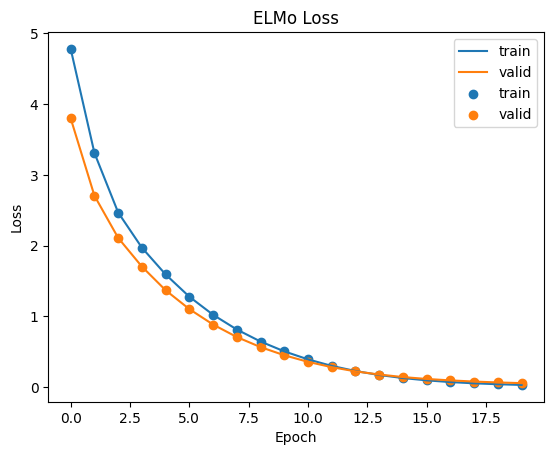

<Figure size 640x480 with 0 Axes>

In [14]:
from matplotlib import pyplot as plt
plt.plot(losses['epoch'], losses['train_loss'], label='train')
plt.plot(losses['epoch'], losses['valid_loss'], label='valid')
# mark with circle 
plt.scatter(losses['epoch'], losses['train_loss'], label='train')
plt.scatter(losses['epoch'], losses['valid_loss'], label='valid')
plt.title('ELMo Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('elmo1_loss.png')


In [15]:
elmo.load_state_dict(torch.load('elmo_model1.pt'))

<All keys matched successfully>

In [16]:
# Parameters
for name, param in elmo.named_parameters():
    if param.requires_grad:
        print(name, param.data, param.shape)
elmo_embeddings = list(elmo.parameters())[0].cpu().detach().numpy()
torch.save(elmo_embeddings, 'elmo_embeddings1.pt')


embedding.weight tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1528, -0.2565, -0.1229,  ...,  0.3585,  0.4474, -0.2414],
        [ 0.0763,  0.2342,  0.1978,  ..., -0.0429, -0.4216,  0.2478],
        ...,
        [ 0.7780,  0.2695,  0.0327,  ..., -0.4202,  0.2208, -0.3912],
        [ 0.2699, -0.2345, -0.0953,  ..., -0.5308,  0.0541,  0.0560],
        [ 0.0957,  0.4627,  0.0849,  ..., -0.3215, -0.1234, -0.2183]],
       device='cuda:0') torch.Size([4208, 300])
lstm1.weight_ih_l0 tensor([[ 0.0325,  0.0244,  0.0233,  ..., -0.0488,  0.0442, -0.1627],
        [ 0.0987, -0.1851,  0.0087,  ...,  0.0095,  0.0662, -0.0979],
        [ 0.0114, -0.0122, -0.1435,  ..., -0.2266, -0.0044, -0.0289],
        ...,
        [ 0.0501,  0.0896,  0.1861,  ...,  0.0297,  0.0052, -0.1195],
        [-0.0526,  0.1304,  0.0380,  ..., -0.0514, -0.1348,  0.4901],
        [-0.3702,  0.3825, -0.0636,  ..., -0.1133, -0.1338, -0.0523]],
       device='cuda:0') torch.Size([400, 300])
l

In [17]:
elmo_lstm1 = elmo.lstm1
print(elmo_lstm1.parameters())
elmo_lstm2 = elmo.lstm2
print(elmo_lstm2.parameters())
elmo_embeddings = list(elmo.parameters())[0].to(device)


<generator object Module.parameters at 0x7fbe20650c80>
<generator object Module.parameters at 0x7fbe20650c80>


In [18]:
from sklearn.metrics import f1_score, confusion_matrix,accuracy_score
class scoreClassifier(nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_dim,elmoEmbedding,elmo_lstm1,elmo_lstm2,num_classes):
        super(scoreClassifier,self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.embeddings = nn.Embedding.from_pretrained(elmoEmbedding, padding_idx=0)
        self.embeddings.weight = nn.Parameter(self.embeddings.weight,requires_grad=
                                              False)
        self.weights = nn.Parameter(torch.tensor([0.33,0.33,0.33]),requires_grad=False)
        self.lstm1 = elmo_lstm1
        self.lstm2 = elmo_lstm2
        self.linear1 = nn.Linear(embedding_dim, hidden_dim*2)
        self.linear_out = nn.Linear(hidden_dim*2, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self,input_data):
        embed = self.embeddings(input_data)
        embedChange = self.linear1(embed)
        lstm1, _ = self.lstm1(embed)
        lstm2, _ = self.lstm2(lstm1)
        elmo_out = (self.weights[0]*lstm1 + self.weights[1]*lstm2 + self.weights[2]*embedChange)/(self.weights[0]+self.weights[1]+self.weights[2])
        elmo_max = torch.max(elmo_out, dim=1)[0]
        elmo_max = self.dropout(elmo_max)
        linear_out = self.linear_out(elmo_max)

        l2_reg = torch.tensor(0.).to(device)
        for param in self.linear1.parameters():
            l2_reg += torch.norm(param,2)
        for param in self.linear_out.parameters():
            l2_reg += torch.norm(param,2)

        # scores = self.relu(linear_out)
        return linear_out, l2_reg


In [19]:
classifier = scoreClassifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, elmo_embeddings, elmo_lstm1, elmo_lstm2, 2)
print(classifier)

scoreClassifier(
  (embeddings): Embedding(4208, 300, padding_idx=0)
  (lstm1): LSTM(300, 100, batch_first=True, bidirectional=True)
  (lstm2): LSTM(200, 100, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=300, out_features=200, bias=True)
  (linear_out): Linear(in_features=200, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [20]:
classifier.to(device)
#Initializing optimizer
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
#Initializing loss function
criterion = nn.CrossEntropyLoss()



In [21]:
def train_classifier_epoch(model, train_dataloader, optimizer, criterion, device):
    model.train()
    train_loss = 0
    iter = 0
    total_acc = 0 
    for batch in tqdm(train_dataloader,desc="Training"):
        optimizer.zero_grad()
        batch = tuple(t.to(device) for t in batch)
        input_data,labels,_,_ = batch
        logits,l2_reg = model(input_data)
        loss = criterion(logits, labels) + 0.001*l2_reg
        loss.backward()
        optimizer.step()
        _,preds = torch.max(logits, dim=1)
        train_acc = accuracy_score(labels.cpu().detach().numpy(), preds.cpu().detach().numpy())
        total_acc += train_acc
        train_loss += loss.item()
        iter += 1
        if iter % 1000 == 0:
            print("Iteration: {}, Train Loss: {}".format(iter, loss.item()))

    return train_loss/len(train_dataloader), total_acc/len(train_dataloader)

def eval_classifier_epoch(model, val_dataloader, criterion, device):
    model.eval()
    losses = 0
    iter = 0
    total_acc = 0
    with torch.no_grad():
        for batch in tqdm(val_dataloader,desc="Validation"):
            batch = tuple(t.to(device) for t in batch)
            input_data,labels,_,_ = batch
            logits,_ = model(input_data)
 
            _,preds = torch.max(logits, dim=1)
            val_acc = accuracy_score(labels.cpu().detach().numpy(), preds.cpu().detach().numpy())
            total_acc += val_acc
            loss = criterion(logits, labels) 
            losses += loss.item()
            iter += 1
            if iter % 500 == 0:
                print("Iteration: {}, Validation Loss: {}".format(iter, loss.item()))
    return losses/len(val_dataloader), total_acc/len(val_dataloader)

def train_classifier(model, train_dataloader, val_dataloader, optimizer, criterion, device, epochs=10):

    losses = {'epoch': [], 'train_loss': [], 'valid_loss': []}
    acc = {'epoch': [], 'train_acc': [], 'valid_acc': []}
    min_valid_loss = float('inf')
    for epoch in range(epochs):
        print("Epoch: {}".format(epoch))

        train_loss,train_acc = train_classifier_epoch(model, train_dataloader, optimizer, criterion, device)
        val_loss,val_acc = eval_classifier_epoch(model, val_dataloader, criterion, device)
        if val_loss < min_valid_loss:
            min_valid_loss = val_loss
            print("Saving model...")
            # torch.save(model.state_dict(), 'elmo2_classifier.pt')

        print("Train Loss: {}, Train Accuracy: {}".format(train_loss,train_acc))
        print("Validation Loss: {}, Validation Accuracy: {}".format(val_loss,val_acc))
        losses['epoch'].append(epoch)
        losses['train_loss'].append(train_loss)
        losses['valid_loss'].append(val_loss)
        acc['epoch'].append(epoch)
        acc['train_acc'].append(train_acc)
        acc['valid_acc'].append(val_acc)
        
    return losses,acc 

train_losses = train_classifier(classifier, train_dataloader, valid_dataloader, optimizer, criterion, device, epochs=25)


Epoch: 0


Validation: 100%|██████████| 35/35 [00:00<00:00, 81.07it/s]


Saving model...
Train Loss: 0.43420602180314866, Train Accuracy: 0.8349719101123596
Validation Loss: 0.7023353951317923, Validation Accuracy: 0.51875
Epoch: 1


Validation: 100%|██████████| 35/35 [00:00<00:00, 66.16it/s]


Train Loss: 0.42194273752554523, Train Accuracy: 0.8319288389513109
Validation Loss: 0.7024373863424573, Validation Accuracy: 0.53125
Epoch: 2


Validation: 100%|██████████| 35/35 [00:00<00:00, 56.29it/s]


Saving model...
Train Loss: 0.4154019868105985, Train Accuracy: 0.8288857677902621
Validation Loss: 0.6728725152356284, Validation Accuracy: 0.5776785714285714
Epoch: 3


Validation: 100%|██████████| 35/35 [00:00<00:00, 59.02it/s]


Saving model...
Train Loss: 0.3977872875801633, Train Accuracy: 0.839185393258427
Validation Loss: 0.6169291964599064, Validation Accuracy: 0.6611950549450549
Epoch: 4


Validation: 100%|██████████| 35/35 [00:00<00:00, 56.80it/s]


Train Loss: 0.38467067962840257, Train Accuracy: 0.8465589887640449
Validation Loss: 0.6492685726710729, Validation Accuracy: 0.6326236263736263
Epoch: 5


Validation: 100%|██████████| 35/35 [00:00<00:00, 60.13it/s]


Train Loss: 0.3841348060786947, Train Accuracy: 0.8424625468164794
Validation Loss: 0.6390794243131365, Validation Accuracy: 0.6513736263736264
Epoch: 6


Validation: 100%|██████████| 35/35 [00:00<00:00, 35.50it/s]


Train Loss: 0.38407313513956715, Train Accuracy: 0.8438670411985019
Validation Loss: 0.6600890572581972, Validation Accuracy: 0.6361950549450549
Epoch: 7


Validation: 100%|██████████| 35/35 [00:00<00:00, 37.68it/s]


Train Loss: 0.3805114700274075, Train Accuracy: 0.8421114232209738
Validation Loss: 0.6677650375025613, Validation Accuracy: 0.6353021978021978
Epoch: 8


Validation: 100%|██████████| 35/35 [00:00<00:00, 52.74it/s]


Train Loss: 0.3731080978439095, Train Accuracy: 0.8473782771535581
Validation Loss: 0.6478226125240326, Validation Accuracy: 0.648695054945055
Epoch: 9


Validation: 100%|██████████| 35/35 [00:00<00:00, 52.53it/s]


Train Loss: 0.36762273300453074, Train Accuracy: 0.8524110486891385
Validation Loss: 0.6575510816914695, Validation Accuracy: 0.6469093406593407
Epoch: 10


Validation: 100%|██████████| 35/35 [00:00<00:00, 52.75it/s]


Train Loss: 0.3589143538463875, Train Accuracy: 0.8520599250936329
Validation Loss: 0.6410675849233355, Validation Accuracy: 0.6576236263736264
Epoch: 11


Validation: 100%|██████████| 35/35 [00:00<00:00, 51.63it/s]


Train Loss: 0.34759551523888155, Train Accuracy: 0.8586142322097379
Validation Loss: 0.6379699106727328, Validation Accuracy: 0.6656593406593406
Epoch: 12


Validation: 100%|██████████| 35/35 [00:00<00:00, 52.80it/s]


Train Loss: 0.34192359383298215, Train Accuracy: 0.8623595505617978
Validation Loss: 0.6274962782859802, Validation Accuracy: 0.6710164835164836
Epoch: 13


Validation: 100%|██████████| 35/35 [00:00<00:00, 51.88it/s]


Train Loss: 0.3309178680516361, Train Accuracy: 0.8677434456928839
Validation Loss: 0.6426023725952421, Validation Accuracy: 0.6603021978021978
Epoch: 14


Validation: 100%|██████████| 35/35 [00:00<00:00, 40.88it/s]


Train Loss: 0.3238423254326935, Train Accuracy: 0.8707865168539326
Validation Loss: 0.6291220064674105, Validation Accuracy: 0.679945054945055
Epoch: 15


Validation: 100%|██████████| 35/35 [00:00<00:00, 37.19it/s]


Train Loss: 0.3106876801462209, Train Accuracy: 0.8765215355805244
Validation Loss: 0.6236403354576656, Validation Accuracy: 0.6924450549450549
Epoch: 16


Validation: 100%|██████████| 35/35 [00:00<00:00, 53.66it/s]


Train Loss: 0.29626377242223156, Train Accuracy: 0.8843632958801498
Validation Loss: 0.6276872898851122, Validation Accuracy: 0.6947115384615384
Epoch: 17


Validation: 100%|██████████| 35/35 [00:00<00:00, 53.66it/s]


Train Loss: 0.2861016093568409, Train Accuracy: 0.8900983146067416
Validation Loss: 0.6386039078235626, Validation Accuracy: 0.6915521978021978
Epoch: 18


Validation: 100%|██████████| 35/35 [00:00<00:00, 52.81it/s]


Train Loss: 0.2704278899824128, Train Accuracy: 0.8977059925093633
Validation Loss: 0.6364005667822702, Validation Accuracy: 0.7022664835164836
Epoch: 19


Validation: 100%|██████████| 35/35 [00:00<00:00, 53.38it/s]


Train Loss: 0.2576260098189897, Train Accuracy: 0.9025046816479401
Validation Loss: 0.64885727422578, Validation Accuracy: 0.7058379120879121
Epoch: 20


Validation: 100%|██████████| 35/35 [00:00<00:00, 52.53it/s]


Train Loss: 0.24143873738327276, Train Accuracy: 0.9082397003745318
Validation Loss: 0.6612593305962426, Validation Accuracy: 0.6986950549450549
Epoch: 21


Validation: 100%|██████████| 35/35 [00:00<00:00, 53.36it/s]


Train Loss: 0.23146333682179898, Train Accuracy: 0.9156132958801498
Validation Loss: 0.6859170709337506, Validation Accuracy: 0.6938186813186813
Epoch: 22


Validation: 100%|██████████| 35/35 [00:00<00:00, 53.23it/s]


Train Loss: 0.21460236106695754, Train Accuracy: 0.925561797752809
Validation Loss: 0.6764276266098023, Validation Accuracy: 0.7045329670329671
Epoch: 23


Validation: 100%|██████████| 35/35 [00:00<00:00, 53.88it/s]


Train Loss: 0.20137365299106091, Train Accuracy: 0.9276685393258427
Validation Loss: 0.6718297362327575, Validation Accuracy: 0.7005494505494506
Epoch: 24


Validation: 100%|██████████| 35/35 [00:00<00:00, 52.41it/s]

Train Loss: 0.1796728078596824, Train Accuracy: 0.9407771535580525
Validation Loss: 0.7431924939155579, Validation Accuracy: 0.6991758241758242


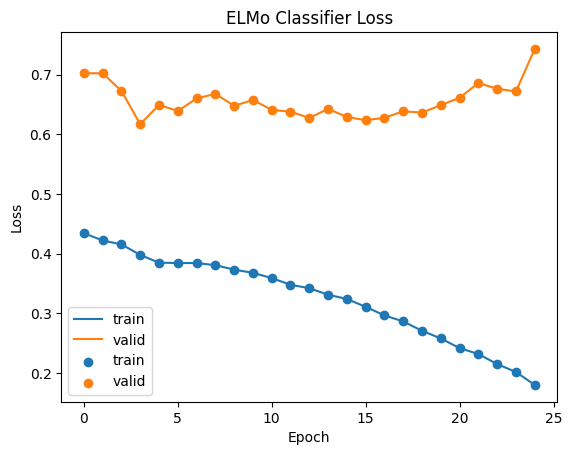

<Figure size 640x480 with 0 Axes>

In [22]:
# Plotting the loss
# train_losses = train_losses
losses,acc = train_losses
plt.plot(losses['epoch'], losses['train_loss'], label='train')
plt.plot(losses['epoch'], losses['valid_loss'], label='valid')
# mark with circle
plt.scatter(losses['epoch'], losses['train_loss'], label='train')
plt.scatter(losses['epoch'], losses['valid_loss'], label='valid')
plt.title('ELMo Classifier Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('elmo1_classifier_loss.png')

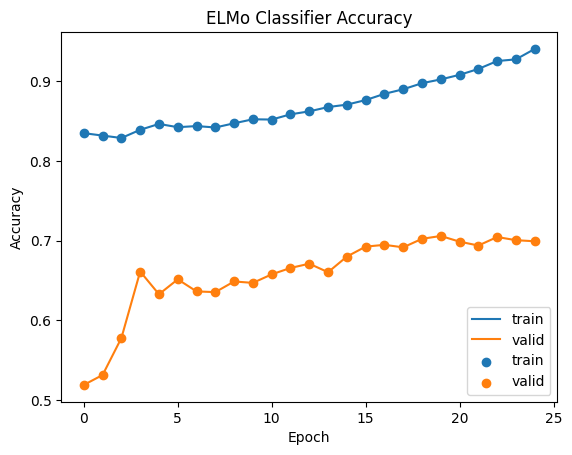

<Figure size 640x480 with 0 Axes>

In [23]:
# Plotting the accuracy
plt.plot(acc['epoch'], acc['train_acc'], label='train')
plt.plot(acc['epoch'], acc['valid_acc'], label='valid')
# mark with circle
plt.scatter(acc['epoch'], acc['train_acc'], label='train')
plt.scatter(acc['epoch'], acc['valid_acc'], label='valid')
plt.title('ELMo Classifier Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig('elmo1_classifier_acc.png')


In [29]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
import numpy as np
classifier.load_state_dict(torch.load('elmo2_classifier.pt'))
classifier.eval()
y_true = []
y_pred = []
confusion_matrix = np.zeros((3,3))

with torch.no_grad():
    for batch in tqdm(test_dataloader,desc="Testing"):
        batch = tuple(t.to(device) for t in batch)
        input_data,labels,_,_ = batch
        logits,_ = classifier(input_data)
        _,preds = torch.max(logits, dim=1)
        y_true.extend(labels.cpu().detach().numpy())
        y_pred.extend(preds.cpu().detach().numpy())
        for i in range(len(labels)):
            confusion_matrix[labels[i]][preds[i]] += 1

print(classification_report(y_true, y_pred, target_names=['negative','neutral','positive'],zero_division=1))
print("Accuracy: {}".format(accuracy_score(y_true, y_pred)))
print("F1 Score: {}".format(f1_score(y_true, y_pred),average='micro'))
print("Precision: {}".format(precision_score(y_true, y_pred),average='micro'))
print("Recall: {}".format(recall_score(y_true, y_pred),average='micro'))
print("Confusion Matrix: ")
print(confusion_matrix)

Testing: 100%|██████████| 615/615 [00:10<00:00, 57.64it/s]


              precision    recall  f1-score   support

    negative       0.35      0.14      0.20      3463
     neutral       1.00      0.00      0.00      3129
    positive       0.33      0.86      0.48      3240

    accuracy                           0.33      9832
   macro avg       0.56      0.33      0.23      9832
weighted avg       0.55      0.33      0.23      9832

Accuracy: 0.33329943043124494
Confusion Matrix: 
[[ 492.    0. 2971.]
 [ 466.    0. 2663.]
 [ 455.    0. 2785.]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# assume y_true and y_scores are your true labels and predicted scores, respectively
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [32]:
classifier.eval()
y_true = []
y_pred = []
confusion_matrix = np.zeros((3, 3))

with torch.no_grad():
    for batch in tqdm(train_dataloader, desc="Testing"):
        batch = tuple(t.to(device) for t in batch)
        input_data, labels, _, _ = batch
        logits, _ = classifier(input_data)
        _, preds = torch.max(logits, dim=1)
        y_true.extend(labels.cpu().detach().numpy())
        y_pred.extend(preds.cpu().detach().numpy())
        for i in range(len(labels)):
            confusion_matrix[labels[i]][preds[i]] += 1

print(classification_report(y_true, y_pred, target_names=['negative', 'neutral', 'positive'], zero_division=1))
print("Accuracy: {}".format(accuracy_score(y_true, y_pred)))
# print("F1 Score: {}".format(f1_score(y_true, y_pred)))
# print("Precision: {}".format(precision_score(y_true, y_pred)))
# print("Recall: {}".format(recall_score(y_true, y_pred)))
print("Confusion Matrix: ")
print(confusion_matrix)


Testing: 100%|██████████| 1913/1913 [01:04<00:00, 29.53it/s]


              precision    recall  f1-score   support

    negative       0.37      0.21      0.27     10371
     neutral       1.00      0.00      0.00      9130
    positive       0.37      0.82      0.51     11105

    accuracy                           0.37     30606
   macro avg       0.58      0.34      0.26     30606
weighted avg       0.56      0.37      0.27     30606

Accuracy: 0.3679997386133438
Confusion Matrix: 
[[2153.    0. 8218.]
 [1645.    0. 7485.]
 [1995.    0. 9110.]]


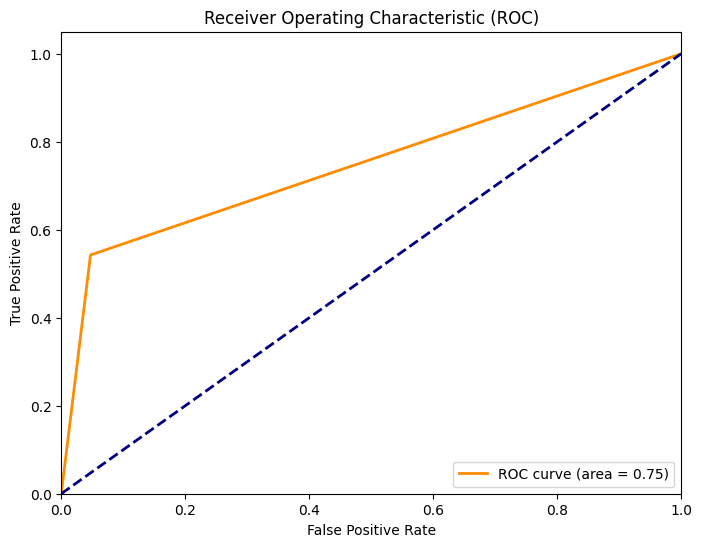

In [152]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# assume y_true and y_scores are your true labels and predicted scores, respectively
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
